# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [1]:
import sklearn.metrics as metrics
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
import warnings
warnings.filterwarnings("ignore")

In [2]:
#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']


# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)

In [3]:
# display df header
data_top = df.head()   
data_top

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Drop null values

In [4]:
df.shape #before dropping nulls

(32561, 15)

In [5]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [6]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [7]:
#df['native-country'].value_counts()

In [8]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [9]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [10]:
df.shape

(27504, 16)

### Visualize the distribution of the categorical features

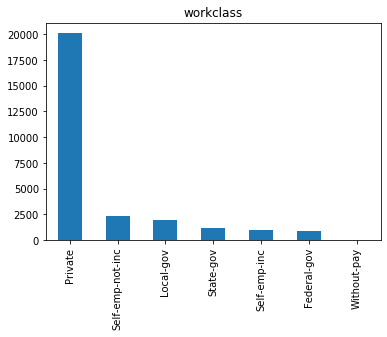

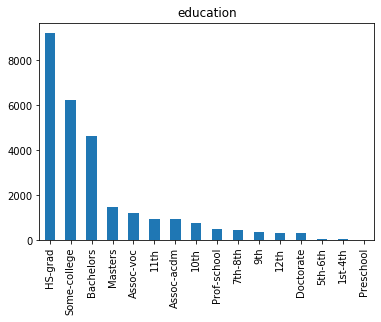

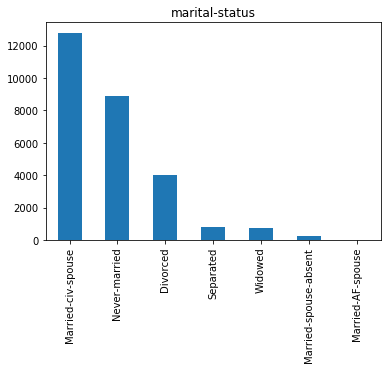

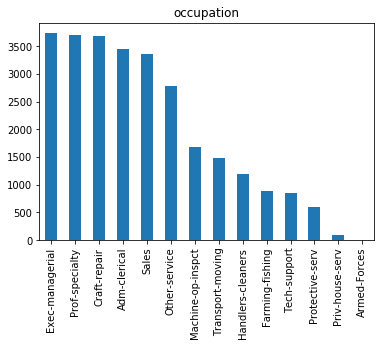

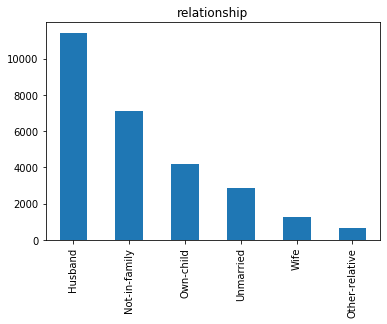

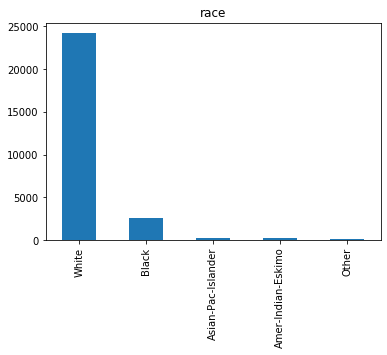

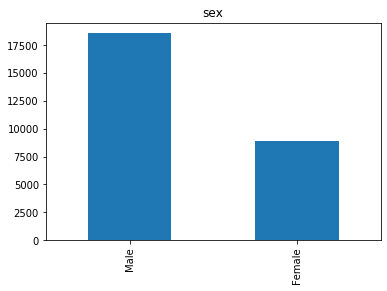

In [11]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

## Visualize the continuous feautures

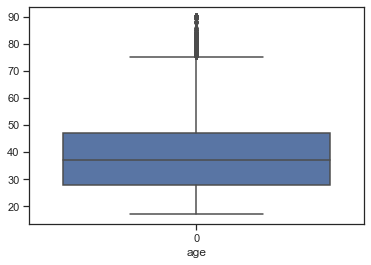

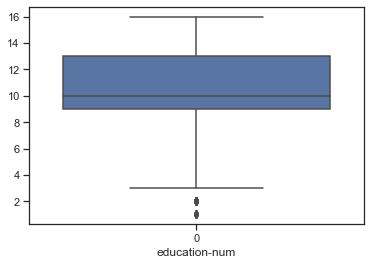

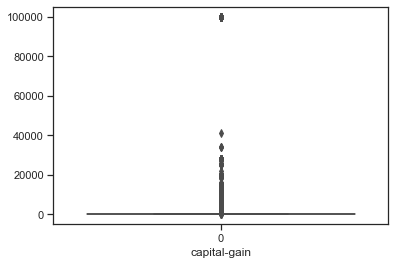

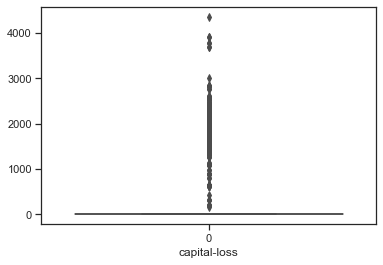

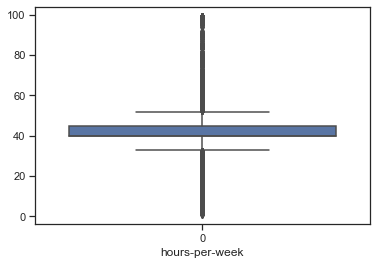

In [12]:
# to do
sns.set(style="ticks", color_codes=True)

string_columns = ['age','education-num','capital-gain',
             'capital-loss','hours-per-week']

for col in string_columns: 
    fig, ax = plt.subplots()
    ax = sns.boxplot(data=df[col]).set(
    xlabel=col
)


### One hot encode

In [13]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]  #non-categorical features (some are not important)
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']  #categorical features we care about
for i in one_hot_cols:  #for every categorical feature, onehot encode it
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))  #if greater than 50k 1 else 0 for label

In [14]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [15]:
new_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,31,45781,14,14084,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,42,159449,13,5178,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
8,37,280464,10,0,0,80,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
9,23,122272,13,0,0,30,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [16]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [17]:
new_df = new_df.reset_index()

In [18]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Permutate/Shuffle the dataframe before applying algorithms

In [19]:
new_df = new_df.reindex(np.random.permutation(new_df.index))
new_df.head(10)

,index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
1061,1061,30,236770,9,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,0
17368,17368,39,421633,10,0,0,30,0,0,1,...,0,0,1,0,0,0,1,0,0,0
6190,6190,50,144361,9,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,1,1
9859,9859,61,61040,10,7688,0,36,0,0,0,...,0,0,0,0,0,0,0,0,1,1
8995,8995,37,497300,9,0,0,40,0,0,1,...,0,0,1,0,0,0,1,0,0,0
5540,5540,39,182828,14,0,0,45,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2713,2713,39,129597,13,3464,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,0
21285,21285,30,341187,4,0,0,35,0,0,1,...,0,0,0,0,0,0,0,0,1,0
19900,19900,29,190330,10,0,0,10,0,1,0,...,0,1,0,0,0,0,0,0,1,0
27241,27241,31,188246,12,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,1,1


### Drop final weight (we don't need it)

In [20]:
new_df.drop(columns = ['fnlwgt'],inplace = True)
new_df.head(10)

,index,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
1061,1061,30,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
17368,17368,39,10,0,0,30,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
6190,6190,50,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
9859,9859,61,10,7688,0,36,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
8995,8995,37,9,0,0,40,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
5540,5540,39,14,0,0,45,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2713,2713,39,13,3464,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
21285,21285,30,4,0,0,35,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
19900,19900,29,10,0,0,10,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
27241,27241,31,12,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


### Get indexes for each individual feature and their respective names

In [21]:
ranges = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,13],[13,20],[20,34],[34,40],[40,45],[1,45]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Function to return results for each classifier

In [22]:
def return_results(clf,string,is_svm,is_dummy,i):
    print('---------- Results Summary for',string,'for the column:',columns[i],'----------')
    print()
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])  #apply standard scaler
    
    X_train = X[:num_training]   #training features 80% of data
    X_test = X[num_training:]    #testing features 20% of data
    Y_train = Y[:num_training]   #training labels 80% of data
    Y_test = Y[num_training:]   #testing labels 20% of data
    start_time = time.time()  #start counting time
    clf.fit(X_train, Y_train) #train algorithm
    scores = 0
    if is_svm == True:  #if it is an svm we do cross validation
        scores = cross_val_score(clf, X_test, Y_test, cv=5)  #5 cross validation folds for accuracy
        scores = max(scores)
    elif is_dummy == True:   #if it is dummy we calculate accuracy differently
        X_trainc, Y_trainc = \
                         check_X_y(X=X_train, y=Y_train)
        clf.fit(X=X_trainc, y=Y_trainc)
        scores = clf.score(X_test,Y_test)
                
    else:
        scores = clf.score(X_test,Y_test) #otherwise use default function
        
    print(str(time.time() - start_time)+" seconds for ", string, " to train") #end time counting and print
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get train accuracy of: ',clf.score(X_train,Y_train))  # train accuracy
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get test accuracy of: ',scores)  # calculate accuracy using 20%
    print()
    
    #confusion matrix
    cf_matrix = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test)),index = ["True <50k", "True >50k"],
                columns = ["Pred <50k", "Pred >50k"])
    print('Confusion Matrix: ')
    print(cf_matrix)
    print()
    
    #f1 score
    score_f1 = f1_score(Y_test, clf.predict(X_test))
    print('F1-score is:',score_f1)

    #plot ROC
    fpr, tpr, thr = metrics.roc_curve(Y_test, clf.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Curve for ' + str(string))
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print()

### Classifiers we will use with different initializations

In [23]:
#classifiers we will use with different initializations
classifiers = [SVC(kernel = 'linear',gamma ='auto',random_state = 50)]
classifiers.append(SVC(kernel = 'linear',gamma ='auto',random_state = 50,class_weight = 'balanced'))
classifiers.append(MLPClassifier(activation = 'relu',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(DummyClassifier(strategy="most_frequent")) #“most_frequent”: always predicts the most frequent label in the training set.

### Name of the Classifiers

In [24]:
names = ['SVM with Linear Kernel','SVM with Linear Kernel and balanced class weight',
         'Neural Network with ReLU activation',
         'Neural Network with Logistic Sigmoid activation',
         'Neural Network with tanh activation', 'Dummy Classifier that predicts most frequent']

### Calculate accuracy per each feature

--------------- Returning Algorithm Results Summary for the feature: Age ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

3.5600318908691406 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7471253919920011
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.74

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


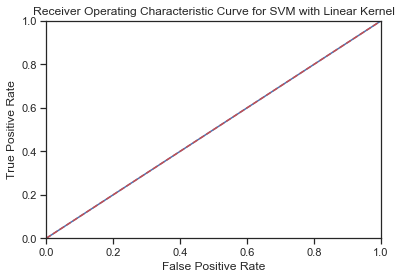


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Age ----------

9.050019979476929 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6232331954733445
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6363636363636364

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2464       1606
True >50k        478        953

F1-score is: 0.4776942355889724


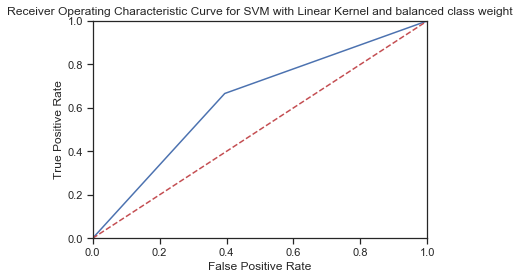


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.17566299438476562 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7471253919920011
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


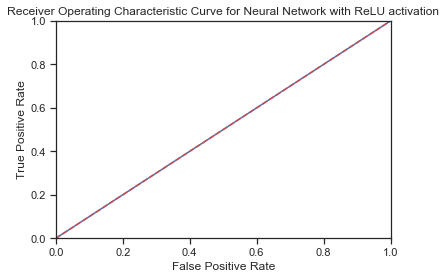


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.5520927906036377 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7471253919920011
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


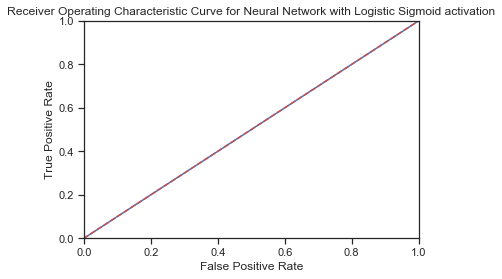


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.2521049976348877 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7471253919920011
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


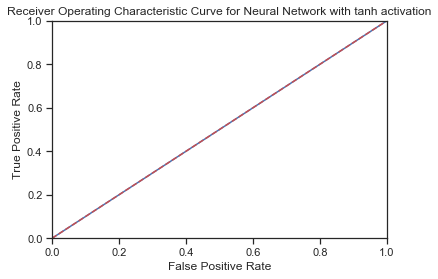


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.0025510787963867188 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


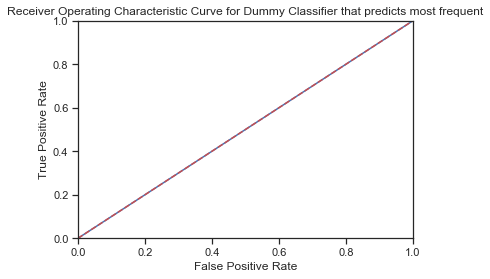


--------------- Returning Algorithm Results Summary for the feature: Education ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

4.725791931152344 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7471253919920011
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.74

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


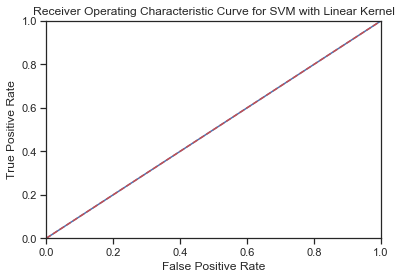


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Education ----------

9.306099891662598 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.728264327591692
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7411444141689373

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3244        826
True >50k        691        740

F1-score is: 0.49382716049382713


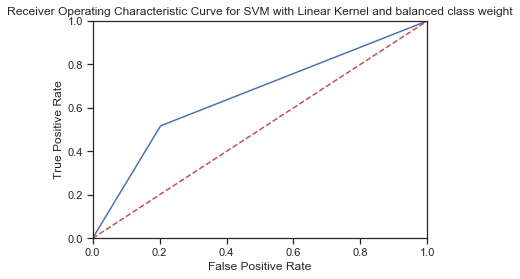


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.5413811206817627 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7703949461437076
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7602254135611707

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3905        165
True >50k       1154        277

F1-score is: 0.29578216764548854


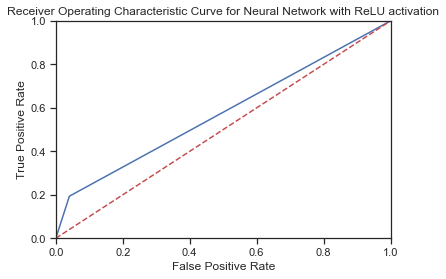


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.2704000473022461 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7703949461437076
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7602254135611707

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3905        165
True >50k       1154        277

F1-score is: 0.29578216764548854


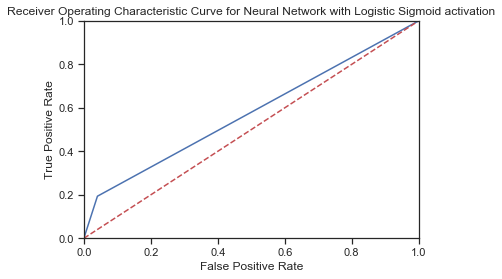


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.2920200824737549 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7703949461437076
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7602254135611707

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3905        165
True >50k       1154        277

F1-score is: 0.29578216764548854


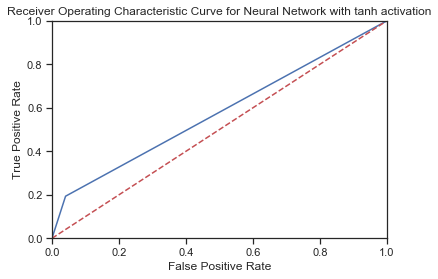


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.002254962921142578 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


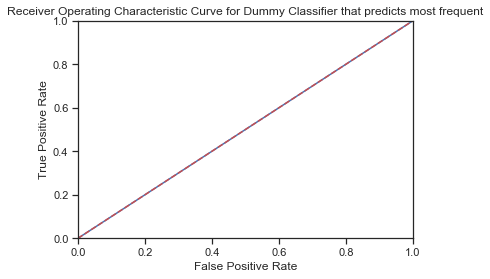


--------------- Returning Algorithm Results Summary for the feature: Capital Gain ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

2.1309010982513428 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7874835249738672
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7872727272727272

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4002         68
True >50k       1161        270

F1-score is: 0.30525720746184287


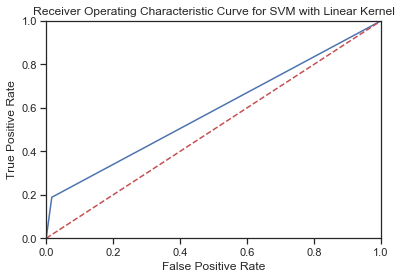


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Gain ----------

4.9915101528167725 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7813934463482253
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7872727272727272

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3937        133
True >50k       1142        289

F1-score is: 0.3119266055045872


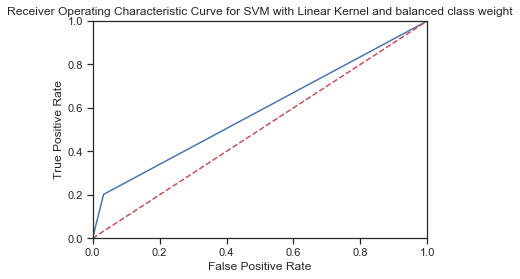


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.4216461181640625 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7935281552515566
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7827667696782403

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4056         14
True >50k       1181        250

F1-score is: 0.2949852507374631


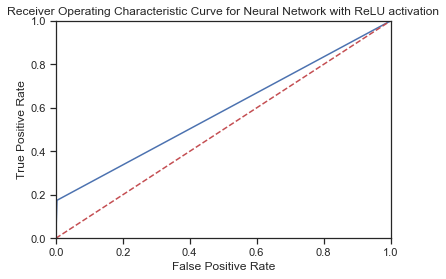


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.2899930477142334 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7915738762895969
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7809489183784767

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4042         28
True >50k       1177        254

F1-score is: 0.2965557501459428


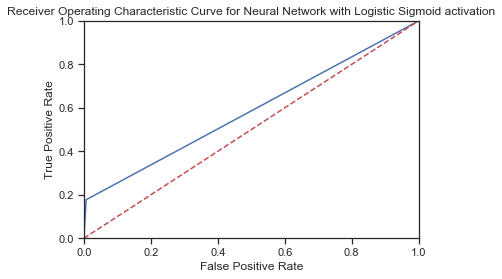


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.24950695037841797 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7903467708948779
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7798582075986185

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4056         14
True >50k       1197        234

F1-score is: 0.27873734365693864


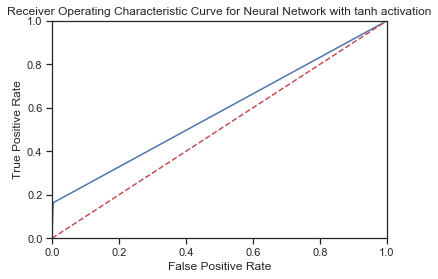


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.0017981529235839844 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


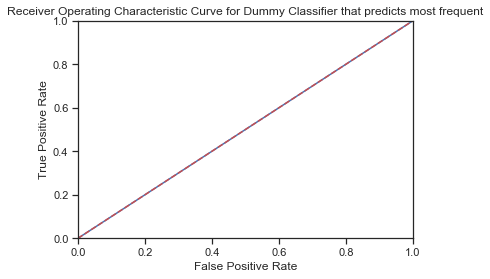


--------------- Returning Algorithm Results Summary for the feature: Capital Loss ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

3.0032801628112793 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7489433259101032
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7538601271571299

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3960        110
True >50k       1277        154

F1-score is: 0.18171091445427728


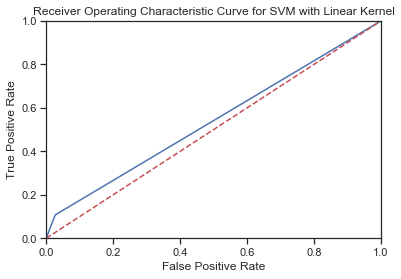


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Loss ----------

5.723986864089966 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7486706358223879
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7538601271571299

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3957        113
True >50k       1277        154

F1-score is: 0.18138987043580682


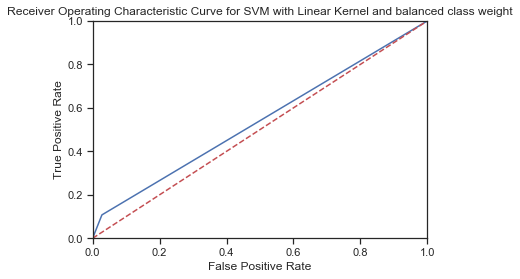


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.0752871036529541 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7471253919920011
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


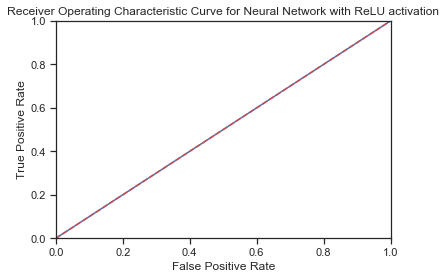


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.6040682792663574 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7605326546380039
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7587711325213597

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4028         42
True >50k       1285        146

F1-score is: 0.18035824583075974


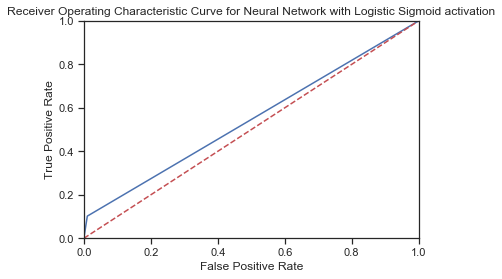


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.9015970230102539 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7605326546380039
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7587711325213597

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4027         43
True >50k       1284        147

F1-score is: 0.18136952498457742


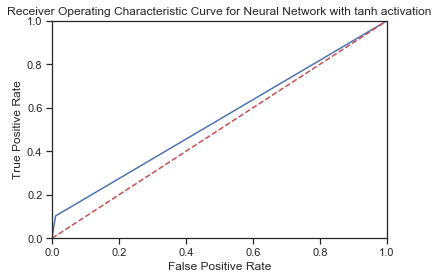


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.0021991729736328125 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


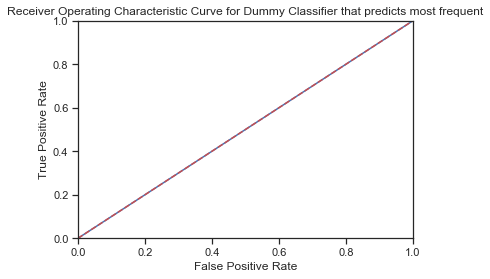


--------------- Returning Algorithm Results Summary for the feature: Hours Per Week ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

6.03531289100647 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7471253919920011
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.74

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


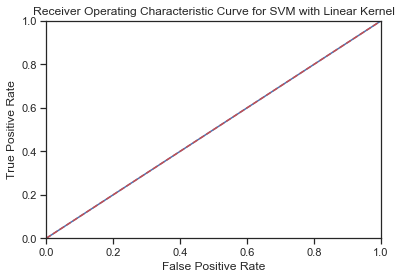


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Hours Per Week ----------

8.96321415901184 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6925419261009862
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7057220708446866

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3137        933
True >50k        726        705

F1-score is: 0.4594330400782014


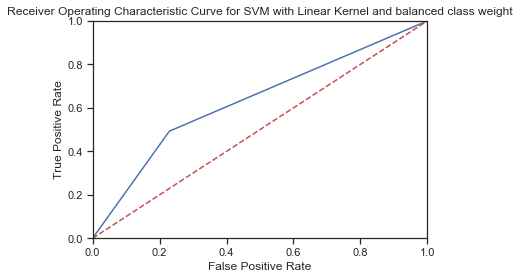


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

0.05179905891418457 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7471253919920011
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


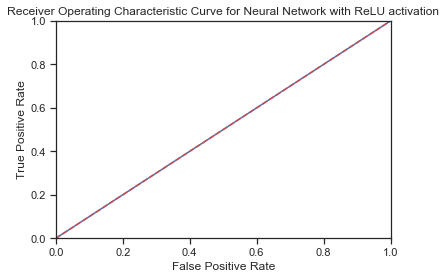


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.255145788192749 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7471253919920011
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


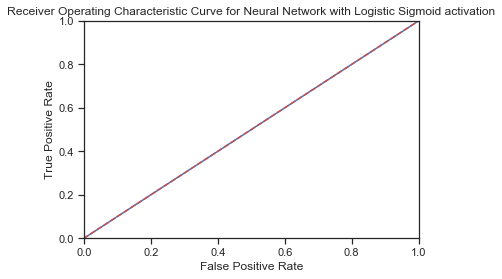


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.19726800918579102 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7471253919920011
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


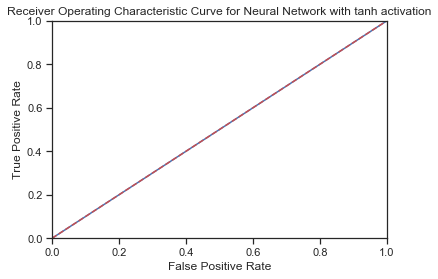


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.0021331310272216797 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


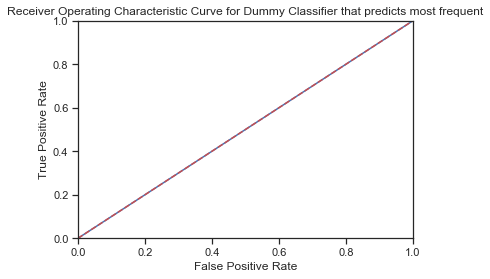


--------------- Returning Algorithm Results Summary for the feature: Workclass ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

3.8074281215667725 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7519429168749716
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7472727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3977         93
True >50k       1319        112

F1-score is: 0.13691931540342298


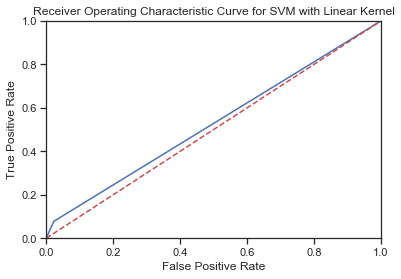


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Workclass ----------

8.71970009803772 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6598191155751488
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7427272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3088        982
True >50k        976        455

F1-score is: 0.3172942817294282


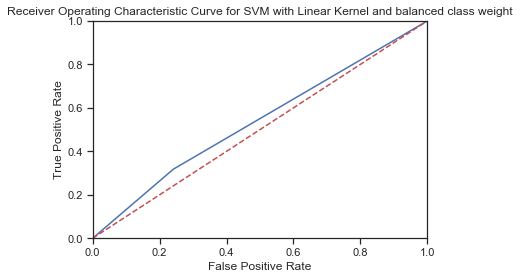


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.31322813034057617 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7519429168749716
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7433193964733685

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3977         93
True >50k       1319        112

F1-score is: 0.13691931540342298


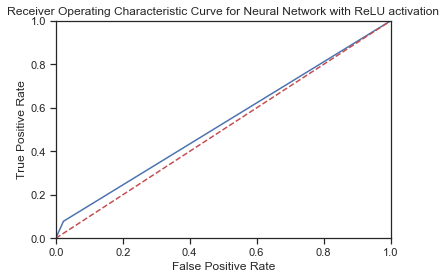


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.3154280185699463 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7519429168749716
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7433193964733685

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3977         93
True >50k       1319        112

F1-score is: 0.13691931540342298


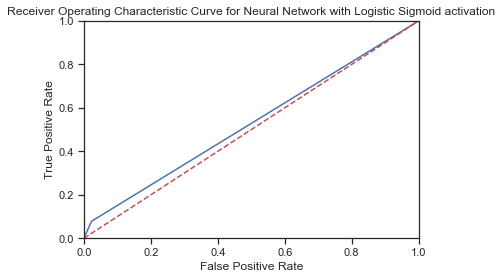


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.2843351364135742 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7519429168749716
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7433193964733685

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3977         93
True >50k       1319        112

F1-score is: 0.13691931540342298


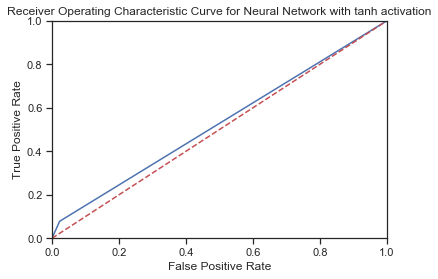


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.0021882057189941406 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


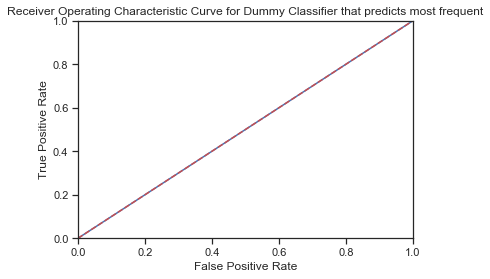


--------------- Returning Algorithm Results Summary for the feature: Marital Status ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

4.776448011398315 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7471253919920011
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.74

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


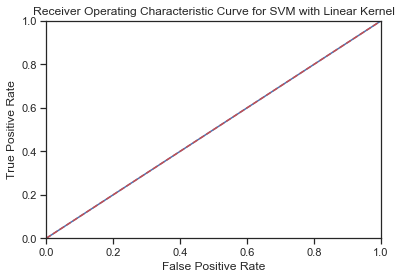


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Marital Status ----------

5.136493921279907 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7133572694632551
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7384196185286104

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2696       1374
True >50k        195       1236

F1-score is: 0.6117297698589459


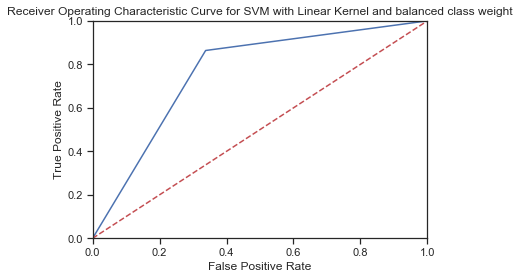


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

0.09130406379699707 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7471253919920011
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


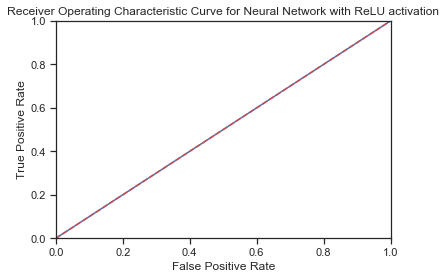


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.48200392723083496 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7471253919920011
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


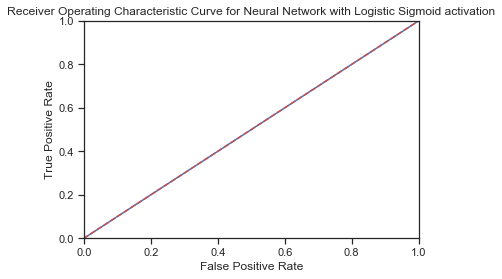


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.3512592315673828 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7471253919920011
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


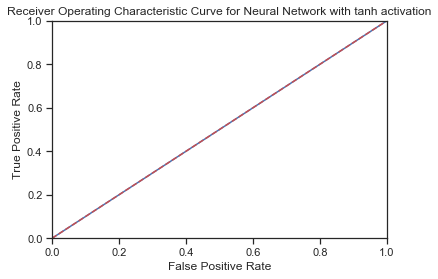


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.0022470951080322266 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


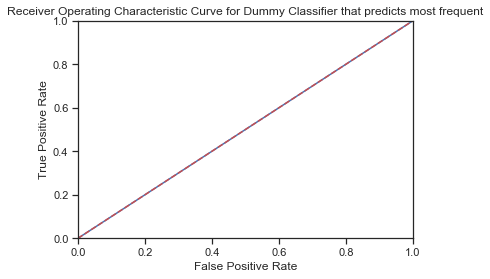


--------------- Returning Algorithm Results Summary for the feature: Occupation ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

6.921343803405762 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7471253919920011
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.74

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


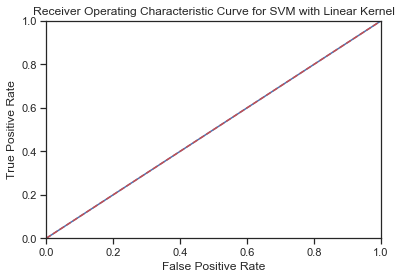


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Occupation ----------

10.549267292022705 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6535017952097442
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6709090909090909

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2610       1460
True >50k        447        984

F1-score is: 0.5078709677419355


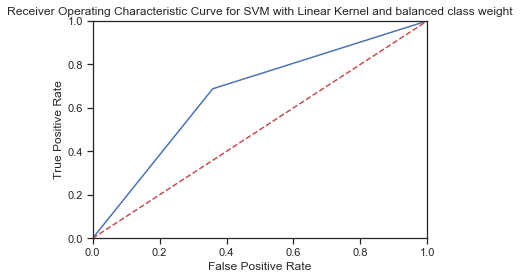


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

0.8493528366088867 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7471253919920011
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


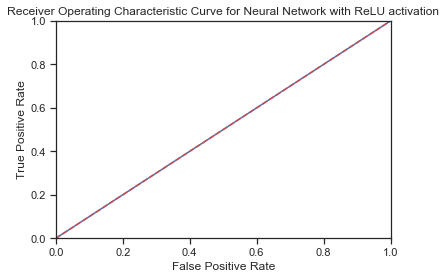


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.34087395668029785 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7471253919920011
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


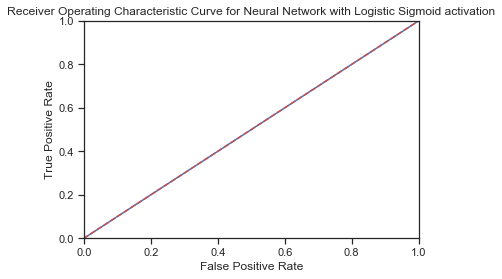


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

0.4750032424926758 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7471253919920011
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


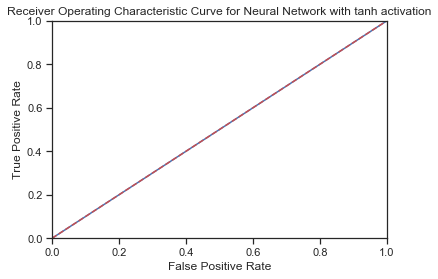


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.002445220947265625 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


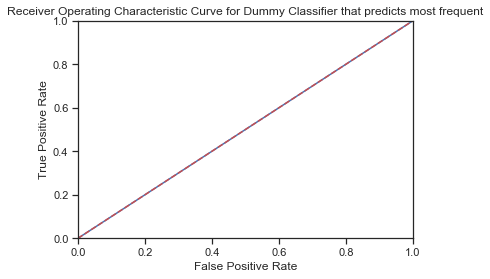


--------------- Returning Algorithm Results Summary for the feature: Relationship ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

4.544067859649658 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7472162886879062
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7545454545454545

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3959        111
True >50k       1303        128

F1-score is: 0.1532934131736527


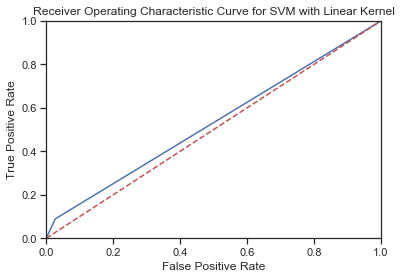


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Relationship ----------

5.490303039550781 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.716402308776076
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7420526793823796

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2728       1342
True >50k        199       1232

F1-score is: 0.6152309612983771


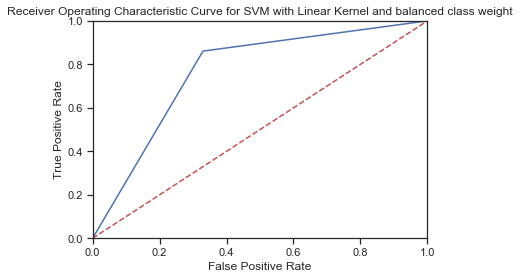


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

0.48703694343566895 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7472162886879062
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7429558262134157

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3959        111
True >50k       1303        128

F1-score is: 0.1532934131736527


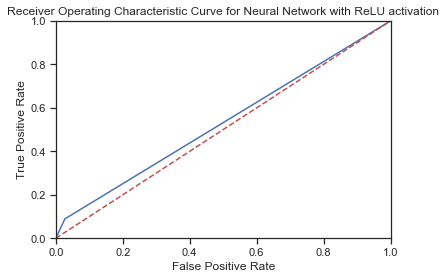


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.3154013156890869 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7471253919920011
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


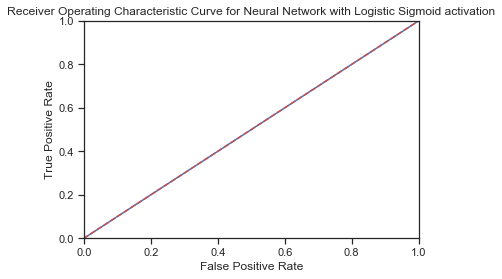


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.48975205421447754 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7471253919920011
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


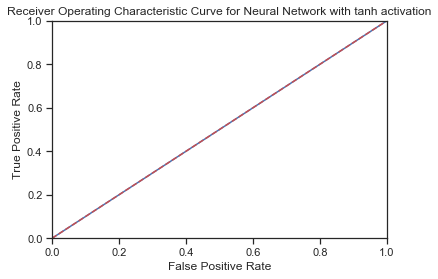


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.0023479461669921875 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


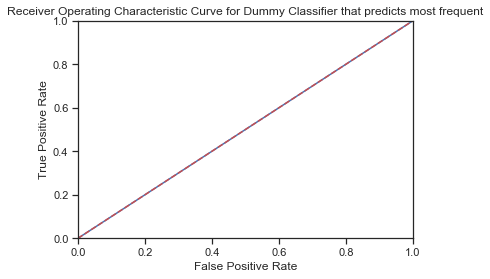


--------------- Returning Algorithm Results Summary for the feature: Race ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

3.5503458976745605 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7471253919920011
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.74

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


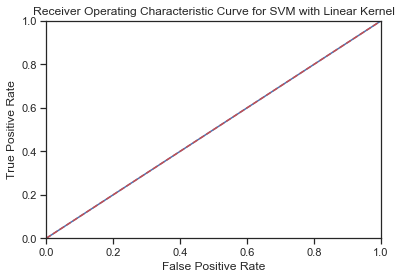


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Race ----------

7.438485860824585 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.33990819433713587
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.3518181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        556       3514
True >50k         97       1334

F1-score is: 0.42490842490842495


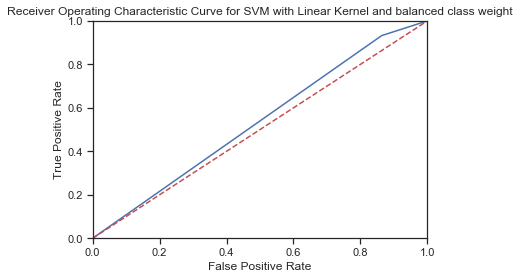


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.4580209255218506 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7471253919920011
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


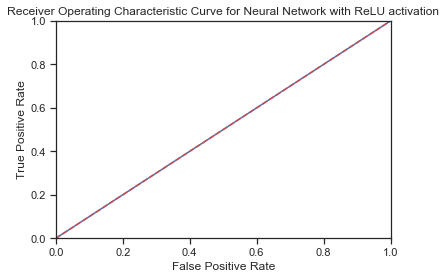


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.24175214767456055 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7471253919920011
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


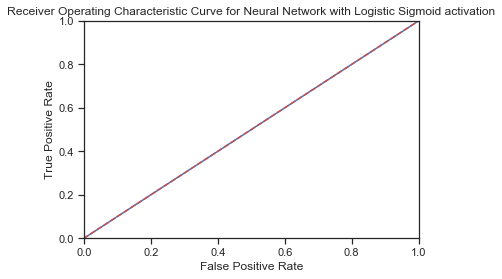


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.23298001289367676 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7471253919920011
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


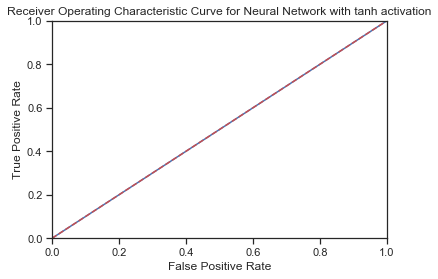


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.0028519630432128906 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


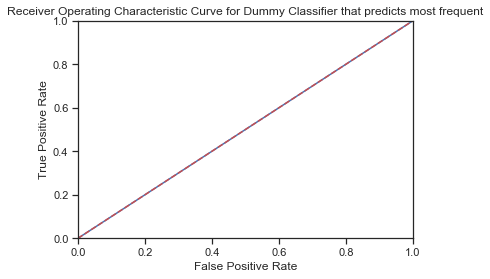


--------------- Returning Algorithm Results Summary for the feature: All Columns ---------------

---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

26.46793794631958 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8456574103531337
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8490909090909091

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3787        283
True >50k        589        842

F1-score is: 0.6588419405320813


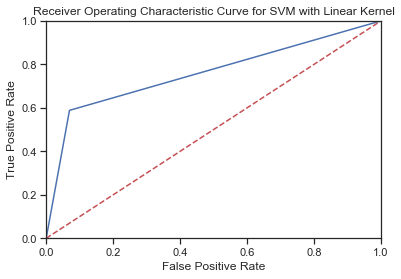


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: All Columns ----------

32.33853006362915 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7907103576784984
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.8029064486830154

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3121        949
True >50k        201       1230

F1-score is: 0.6814404432132964


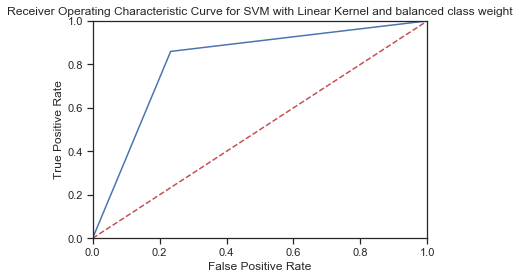


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

1.6172940731048584 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8539744580284506
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8442101436102527

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3758        312
True >50k        545        886

F1-score is: 0.6740205401293268


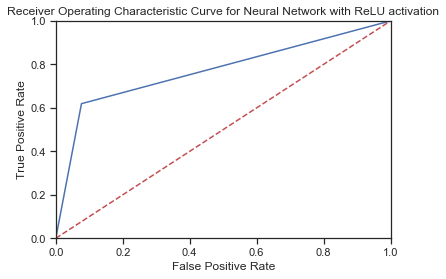


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

1.2749009132385254 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8547016315956915
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8482094164697328

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3774        296
True >50k        539        892

F1-score is: 0.681176021382207


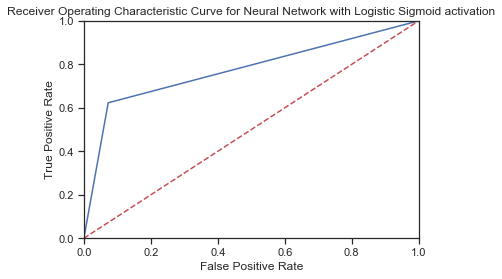


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

1.507340908050537 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8551106667272644
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8449372841301581

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3774        296
True >50k        557        874

F1-score is: 0.6720492118415994


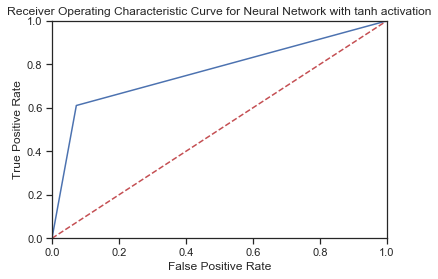


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.0034999847412109375 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7471253919920011
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7398654790038175

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4070          0
True >50k       1431          0

F1-score is: 0.0


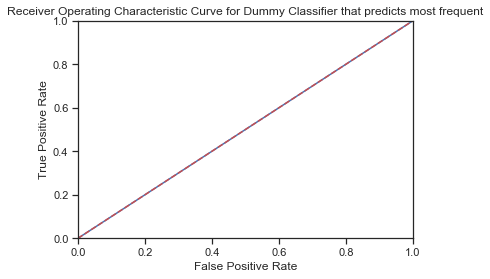

In [25]:
Y = np.array(new_df.iloc[:,45:46]) #labels
num_training = int(0.8*Y.shape[0])  #80% of the data for training
sc = StandardScaler()

for i in range(len(ranges)):
    print('--------------- Returning Algorithm Results Summary for the feature:',columns[i],'---------------')
    print()
    for j in range(len(classifiers)):
        if j == 0 or j == 1:   # if it is svm do cross validation
            return_results(classifiers[j],names[j],True,False,i)
        elif j == 5:  # if it is a dummyclassifier, calculate accuracy the proper way
            return_results(classifiers[j],names[j],False,True,i)  
        else:    # if a regular classifier, just do the normal operations
            return_results(classifiers[j],names[j],False,False,i)